In [4]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

def preprocess(data_array: np.ndarray, train_size: float):
    """Splits data into train/val/test sets and normalizes the data."""
    num_time_steps = data_array.shape[0]
    num_train = int(num_time_steps * train_size)
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)
    train_array = (train_array - mean) / std
    test_array = (data_array[num_train:] - mean) / std
    return train_array, test_array

# Load your data
data = pd.read_csv('/content/number_services_called.csv').fillna(0).to_numpy()

# Preprocess the data
train_array, test_array = preprocess(data, 0.7)
x_train = train_array[:, :]
y_train = train_array[:, :]  # Predicting all features, so y is the same as x
x_test = test_array[:, :]
y_test = test_array[:, :]

# Reshape the data for the model
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

# Shuffle the training set
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    output_layer = keras.layers.Dense(input_shape[0])(gap)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

epochs = 200
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001)
]

# Compile the model with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=["mse","mape"],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)



Epoch 1/200
101/101 [==============================] - 5s 24ms/step - loss: 0.4354 - mse: 0.4354 - mape: 482.0248 - val_loss: 0.7979 - val_mse: 0.7979 - val_mape: 210.6458 - lr: 0.0010
Epoch 2/200
101/101 [==============================] - 3s 28ms/step - loss: 0.2220 - mse: 0.2220 - mape: 451.0815 - val_loss: 0.6503 - val_mse: 0.6503 - val_mape: 240.5006 - lr: 0.0010
Epoch 3/200
101/101 [==============================] - 2s 17ms/step - loss: 0.1603 - mse: 0.1603 - mape: 439.4062 - val_loss: 0.5838 - val_mse: 0.5838 - val_mape: 253.9702 - lr: 0.0010
Epoch 4/200
101/101 [==============================] - 2s 18ms/step - loss: 0.1113 - mse: 0.1113 - mape: 430.8925 - val_loss: 0.3960 - val_mse: 0.3960 - val_mape: 269.7665 - lr: 0.0010
Epoch 5/200
101/101 [==============================] - 2s 17ms/step - loss: 0.0803 - mse: 0.0803 - mape: 380.8273 - val_loss: 0.1449 - val_mse: 0.1449 - val_mape: 200.7854 - lr: 0.0010
Epoch 6/200
101/101 [==============================] - 3s 27ms/step - loss:

55/55 [==============================] - 1s 5ms/step - loss: 0.0039 - mse: 0.0039 - mape: 70.4950
[0.003919939510524273, 0.003919939510524273, 70.49496459960938]
Test MSE 0.003919939510524273
Test loss 0.003919939510524273


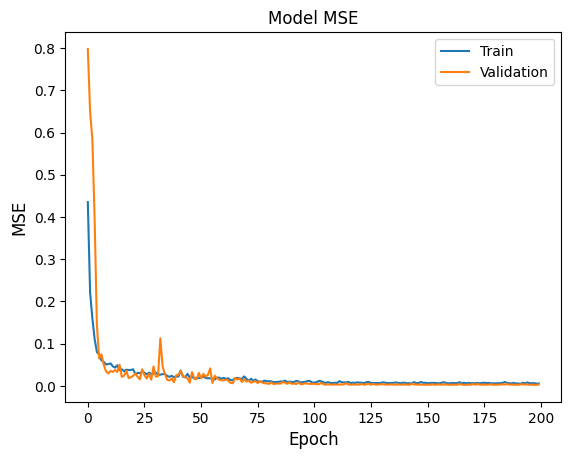

In [8]:
model = keras.models.load_model("best_model.keras")

# Check the output of model.evaluate()
evaluation_results = model.evaluate(x_test, y_test)
print(evaluation_results)  # Print to see what is returned

# Assign the results accordingly
test_loss = evaluation_results[0]
test_mse = evaluation_results[1]

print("Test MSE", test_mse)
print("Test loss", test_loss)


plt.figure()
plt.plot(history.history["mse"])
plt.plot(history.history["val_mse"])
plt.title("Model MSE")
plt.ylabel("MSE", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["Train", "Validation"], loc="best")
plt.show()
plt.close()

In [11]:
def plot_real_vs_predicted_single(real, predicted):
    """Plots the real values vs predicted values for a single time step."""
    plt.figure(figsize=(10, 6))
    plt.plot(real, label='Real Values', marker='o')
    plt.plot(predicted, label='Predicted Values', marker='x')
    plt.title('Real vs Predicted Values for a Single Sample')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

55/55 [==============================] - 0s 8ms/step


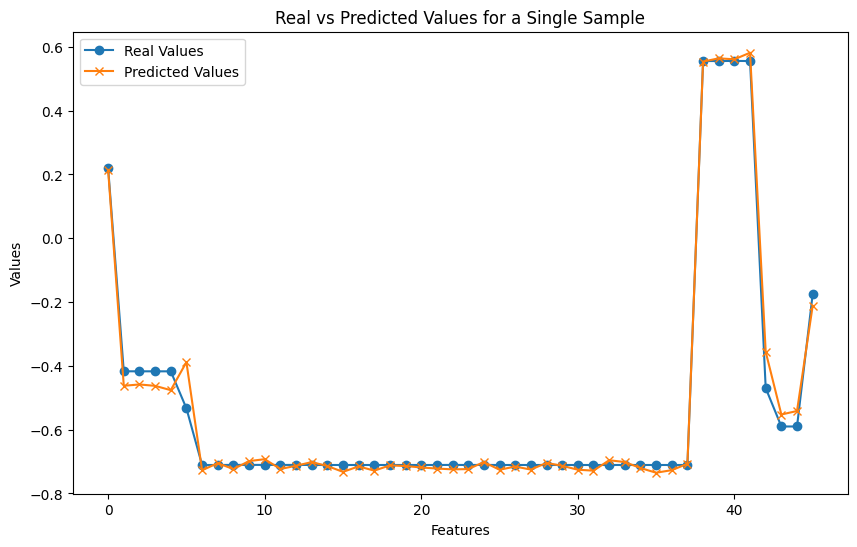

In [17]:
# Predict using the model
y_pred = model.predict(x_test)

# Since y_test and y_pred are 3D arrays, we need to reshape them for plotting
y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_pred_reshaped = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])

# Plot real vs predicted values for a single sample
plot_real_vs_predicted_single(y_test_reshaped[0], y_pred_reshaped[0])